In [1]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf

In [2]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14 (1).csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns=['areaType','cumCasesBySpecimenDate','cumCasesBySpecimenDateRate'],inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20_additional['date'] = pd.to_datetime(cases20_additional['date'])
cases20_additional = cases20_additional[cases20_additional['date'] < '2020-11-01']
cases20_additional = cases20_additional[cases20_additional['date'] >= '2020-10-01']
cases20 = pd.concat([cases20,cases20_additional]).sort_index()
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date', inplace=True)
cases.sort_index(inplace=True)
weekly_counts_total = cases.groupby(['area_code','area_name']).rolling(7).sum().reset_index()
# Convert incidence to a proportion to allow for cross-LTLA comparison
weekly_counts_total = pd.merge(weekly_counts_total,pop,on='area_code')
weekly_counts_total['incidence'] = weekly_counts_total['value'] / weekly_counts_total['population']

In [3]:
# Add in the ITL regions for spatial detrending
npis = pd.read_csv('Data/npis_23Mar_02Dec.csv')
npis = npis[['ltla20nm','region']]
npis.drop_duplicates(inplace=True)

manual_dat = pd.DataFrame({'ltla20nm': ['Wycombe','South Bucks','Chiltern','Aylesbury Vale'], \
                           'region': ['South East', 'South East', 'South East', 'South East']})
npis = pd.concat([npis,manual_dat])

In [4]:
# Cases with ITL regions
cases_region = pd.merge(cases.reset_index(), npis, left_on='area_name', right_on='ltla20nm')
cases_region.drop(columns='ltla20nm',inplace=True)

In [5]:
# Add in the ITL regions for spatial detrending
weekly_counts_total = pd.merge(weekly_counts_total, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_total.drop(columns='ltla20nm',inplace=True)

In [6]:
# Get the regional mean inicidences and spatially detrend
regional_mean_total = weekly_counts_total.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean_total.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_total = pd.merge(weekly_counts_total, regional_mean_total, on=['region', 'date'])
weekly_counts_total['detrended'] = weekly_counts_total['incidence'] - weekly_counts_total['regional_mean_incidence']

In [34]:
# Convert to wide format for ease of future calculations
wide_data_total = weekly_counts_total.pivot(index='date', columns='area_name', values='detrended')
wide_data_incidence = weekly_counts_total.pivot(index='date', columns='area_name', values='incidence')

In [13]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [14]:
# Get signals short windows
ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)
# Get signals long windows
ews_10total, norm_ews_10total = calculate_ews_rolling(wide_data_total,window_size=10)
ews_30total, norm_ews_30total = calculate_ews_rolling(wide_data_total,window_size=30)

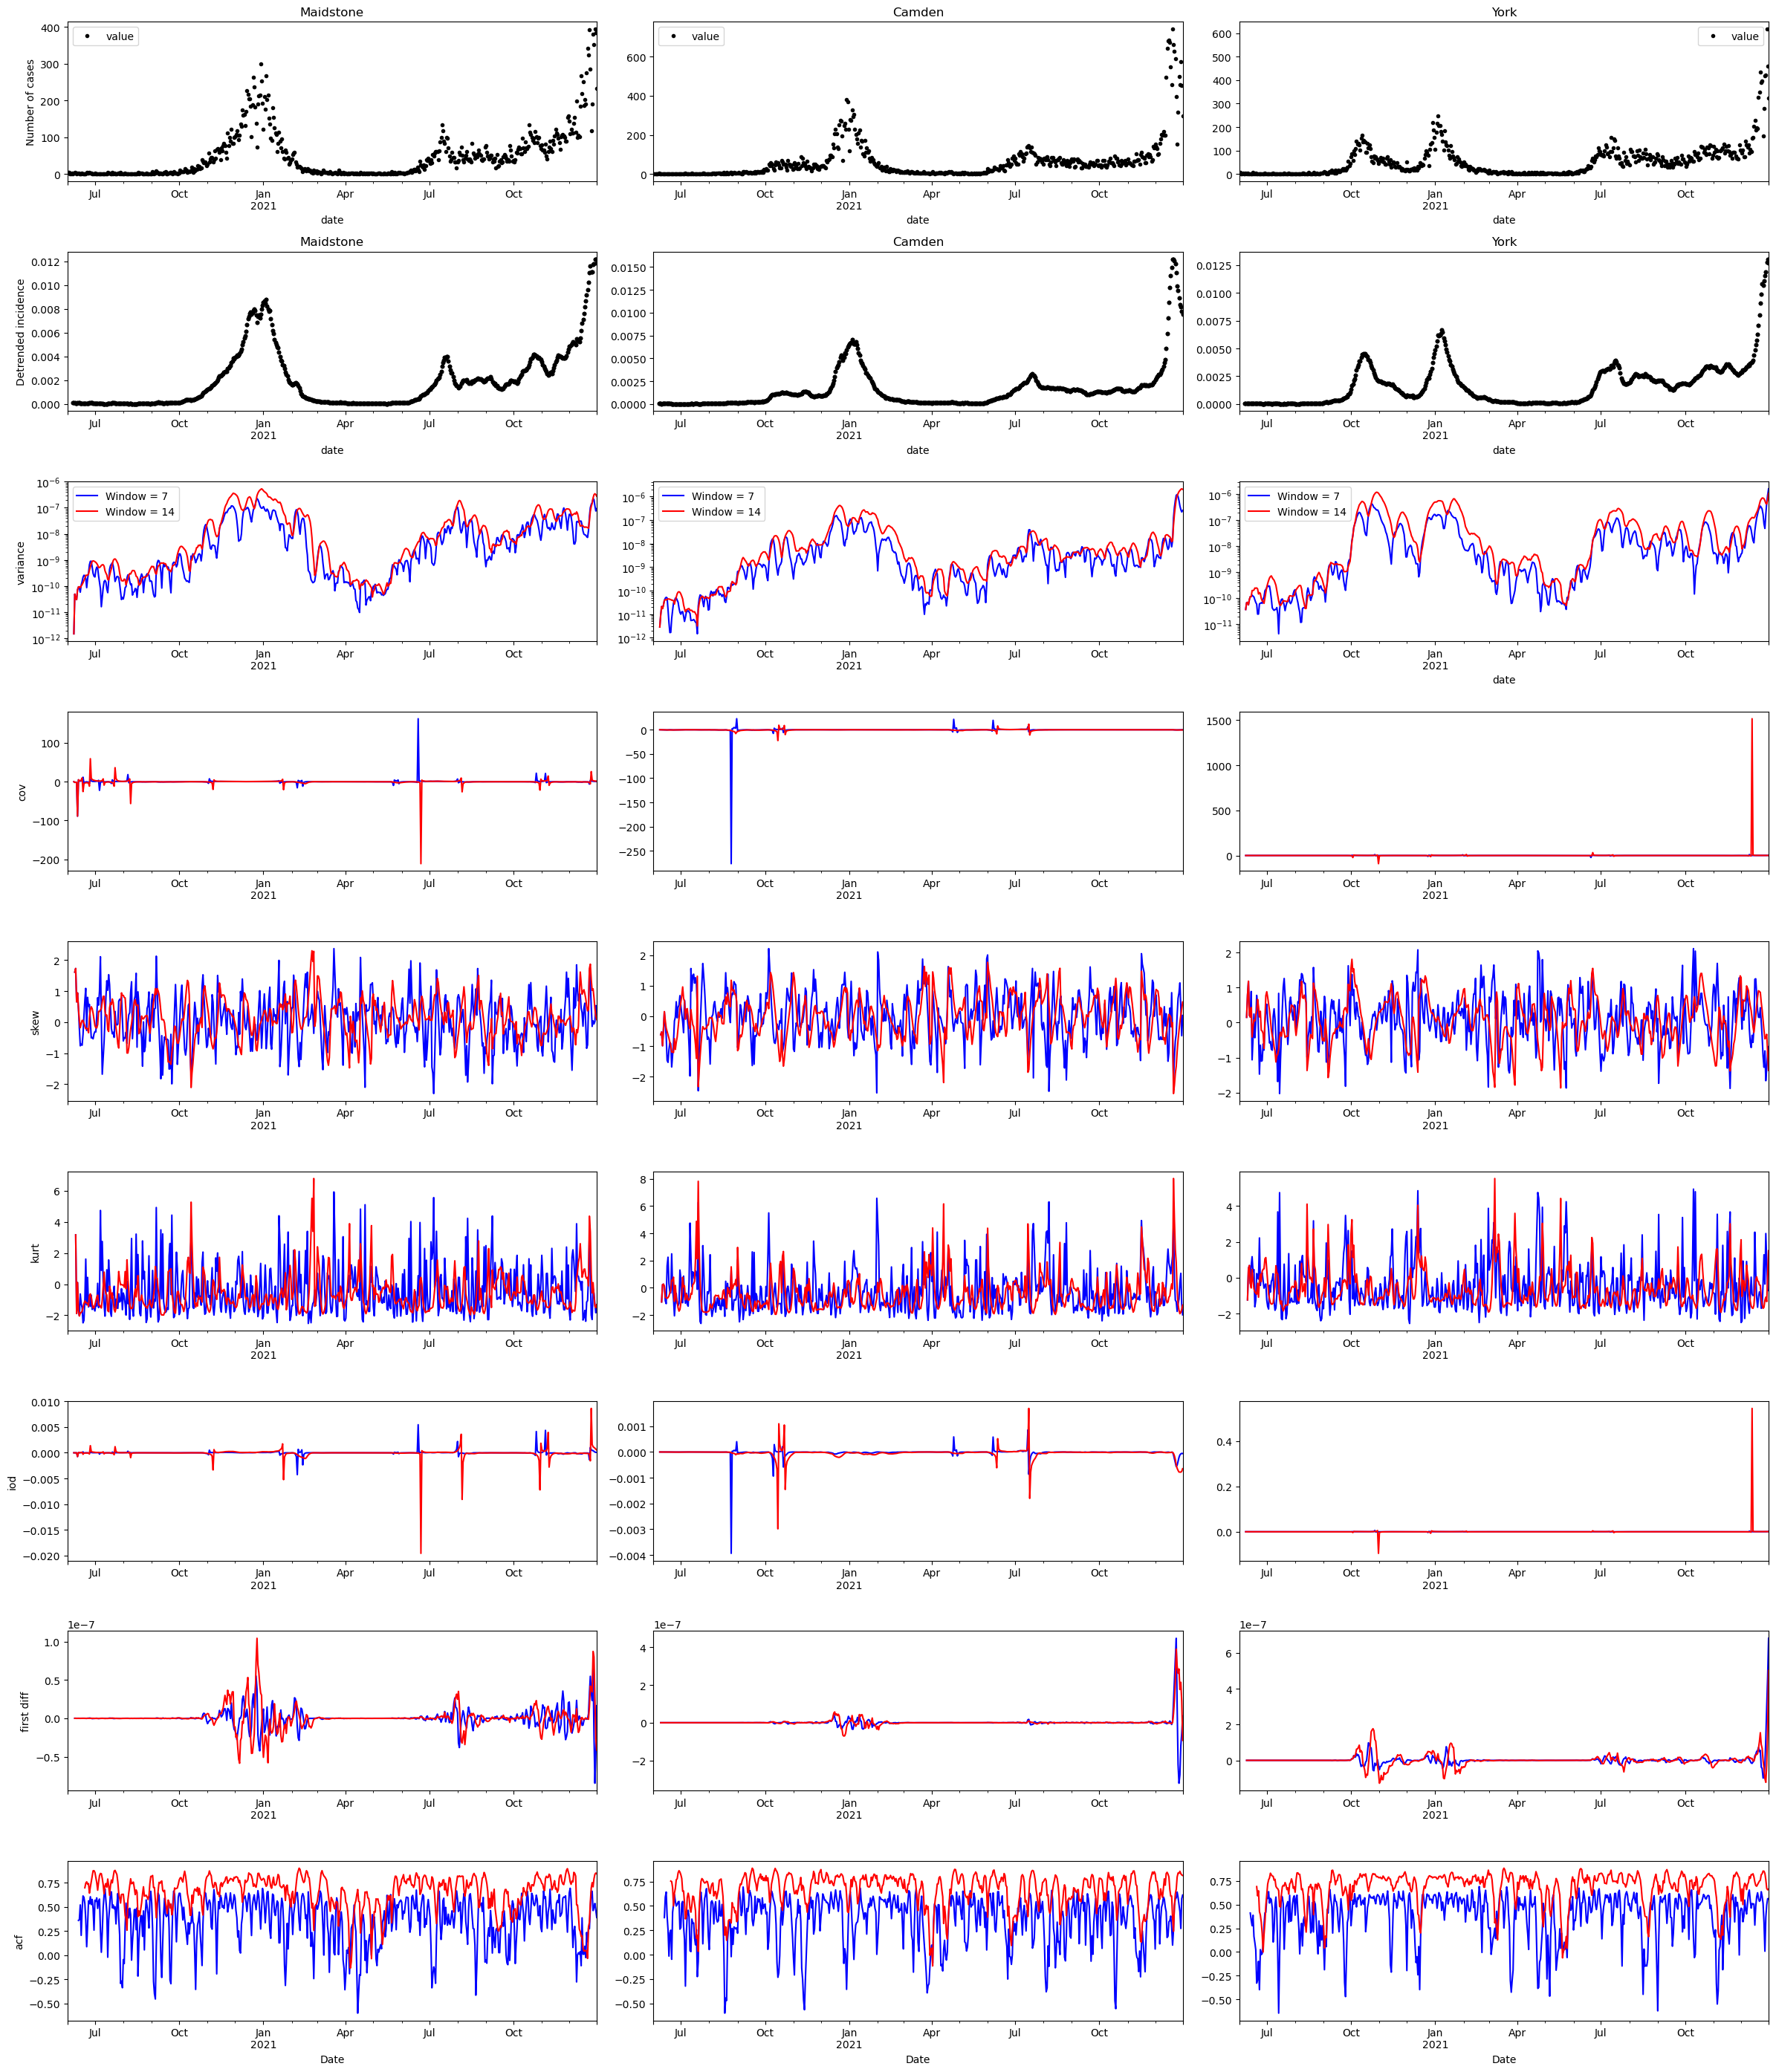

In [35]:
fig, axs = plt.subplots(nrows=len(ews_7total.keys())+2,ncols=3,figsize=(24,28))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')

for i in range(3):
    wide_data_incidence['Maidstone'].plot(style='.',ax=axs[1,0],color='black')
    axs[1,0].set_title('Maidstone')
    wide_data_incidence['Camden'].plot(style='.',ax=axs[1,1],color='black')
    axs[1,1].set_title('Camden')
    wide_data_incidence['York'].plot(style='.',ax=axs[1,2],color='black')
    axs[1,2].set_title('York')
    axs[1,0].set_ylabel('Detrended incidence')

for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_14total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+2,0],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+2,0],logy=True,color='red',label='Window = 14')
        axs[i+2,0].legend()
    else:
        y_data.plot(ax=axs[i+2,0],color='blue')
        x_data.plot(ax=axs[i+2,0],color='red')
    axs[i+2,0].set_ylabel(stat)
    axs[i+2,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_14total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+2,1],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+2,1],logy=True,color='red',label='Window = 14')
        axs[i+2,1].legend()
    else:
        y_data.plot(ax=axs[i+2,1],color='blue')
        x_data.plot(ax=axs[i+2,1],color='red')
    axs[i+2,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['York']
    stat_data = ews_14total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+2,2],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+2,2],logy=True,color='red',label='Window = 14')
        axs[i+2,2].legend()
    else:
        y_data.plot(ax=axs[i+2,2],color='blue')
        x_data.plot(ax=axs[i+2,2],color='red')
        axs[i+2,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.tight_layout()
plt.savefig("Figures/spatialrolling714full.pdf",dpi=2400,bbox_inches='tight')
plt.show()

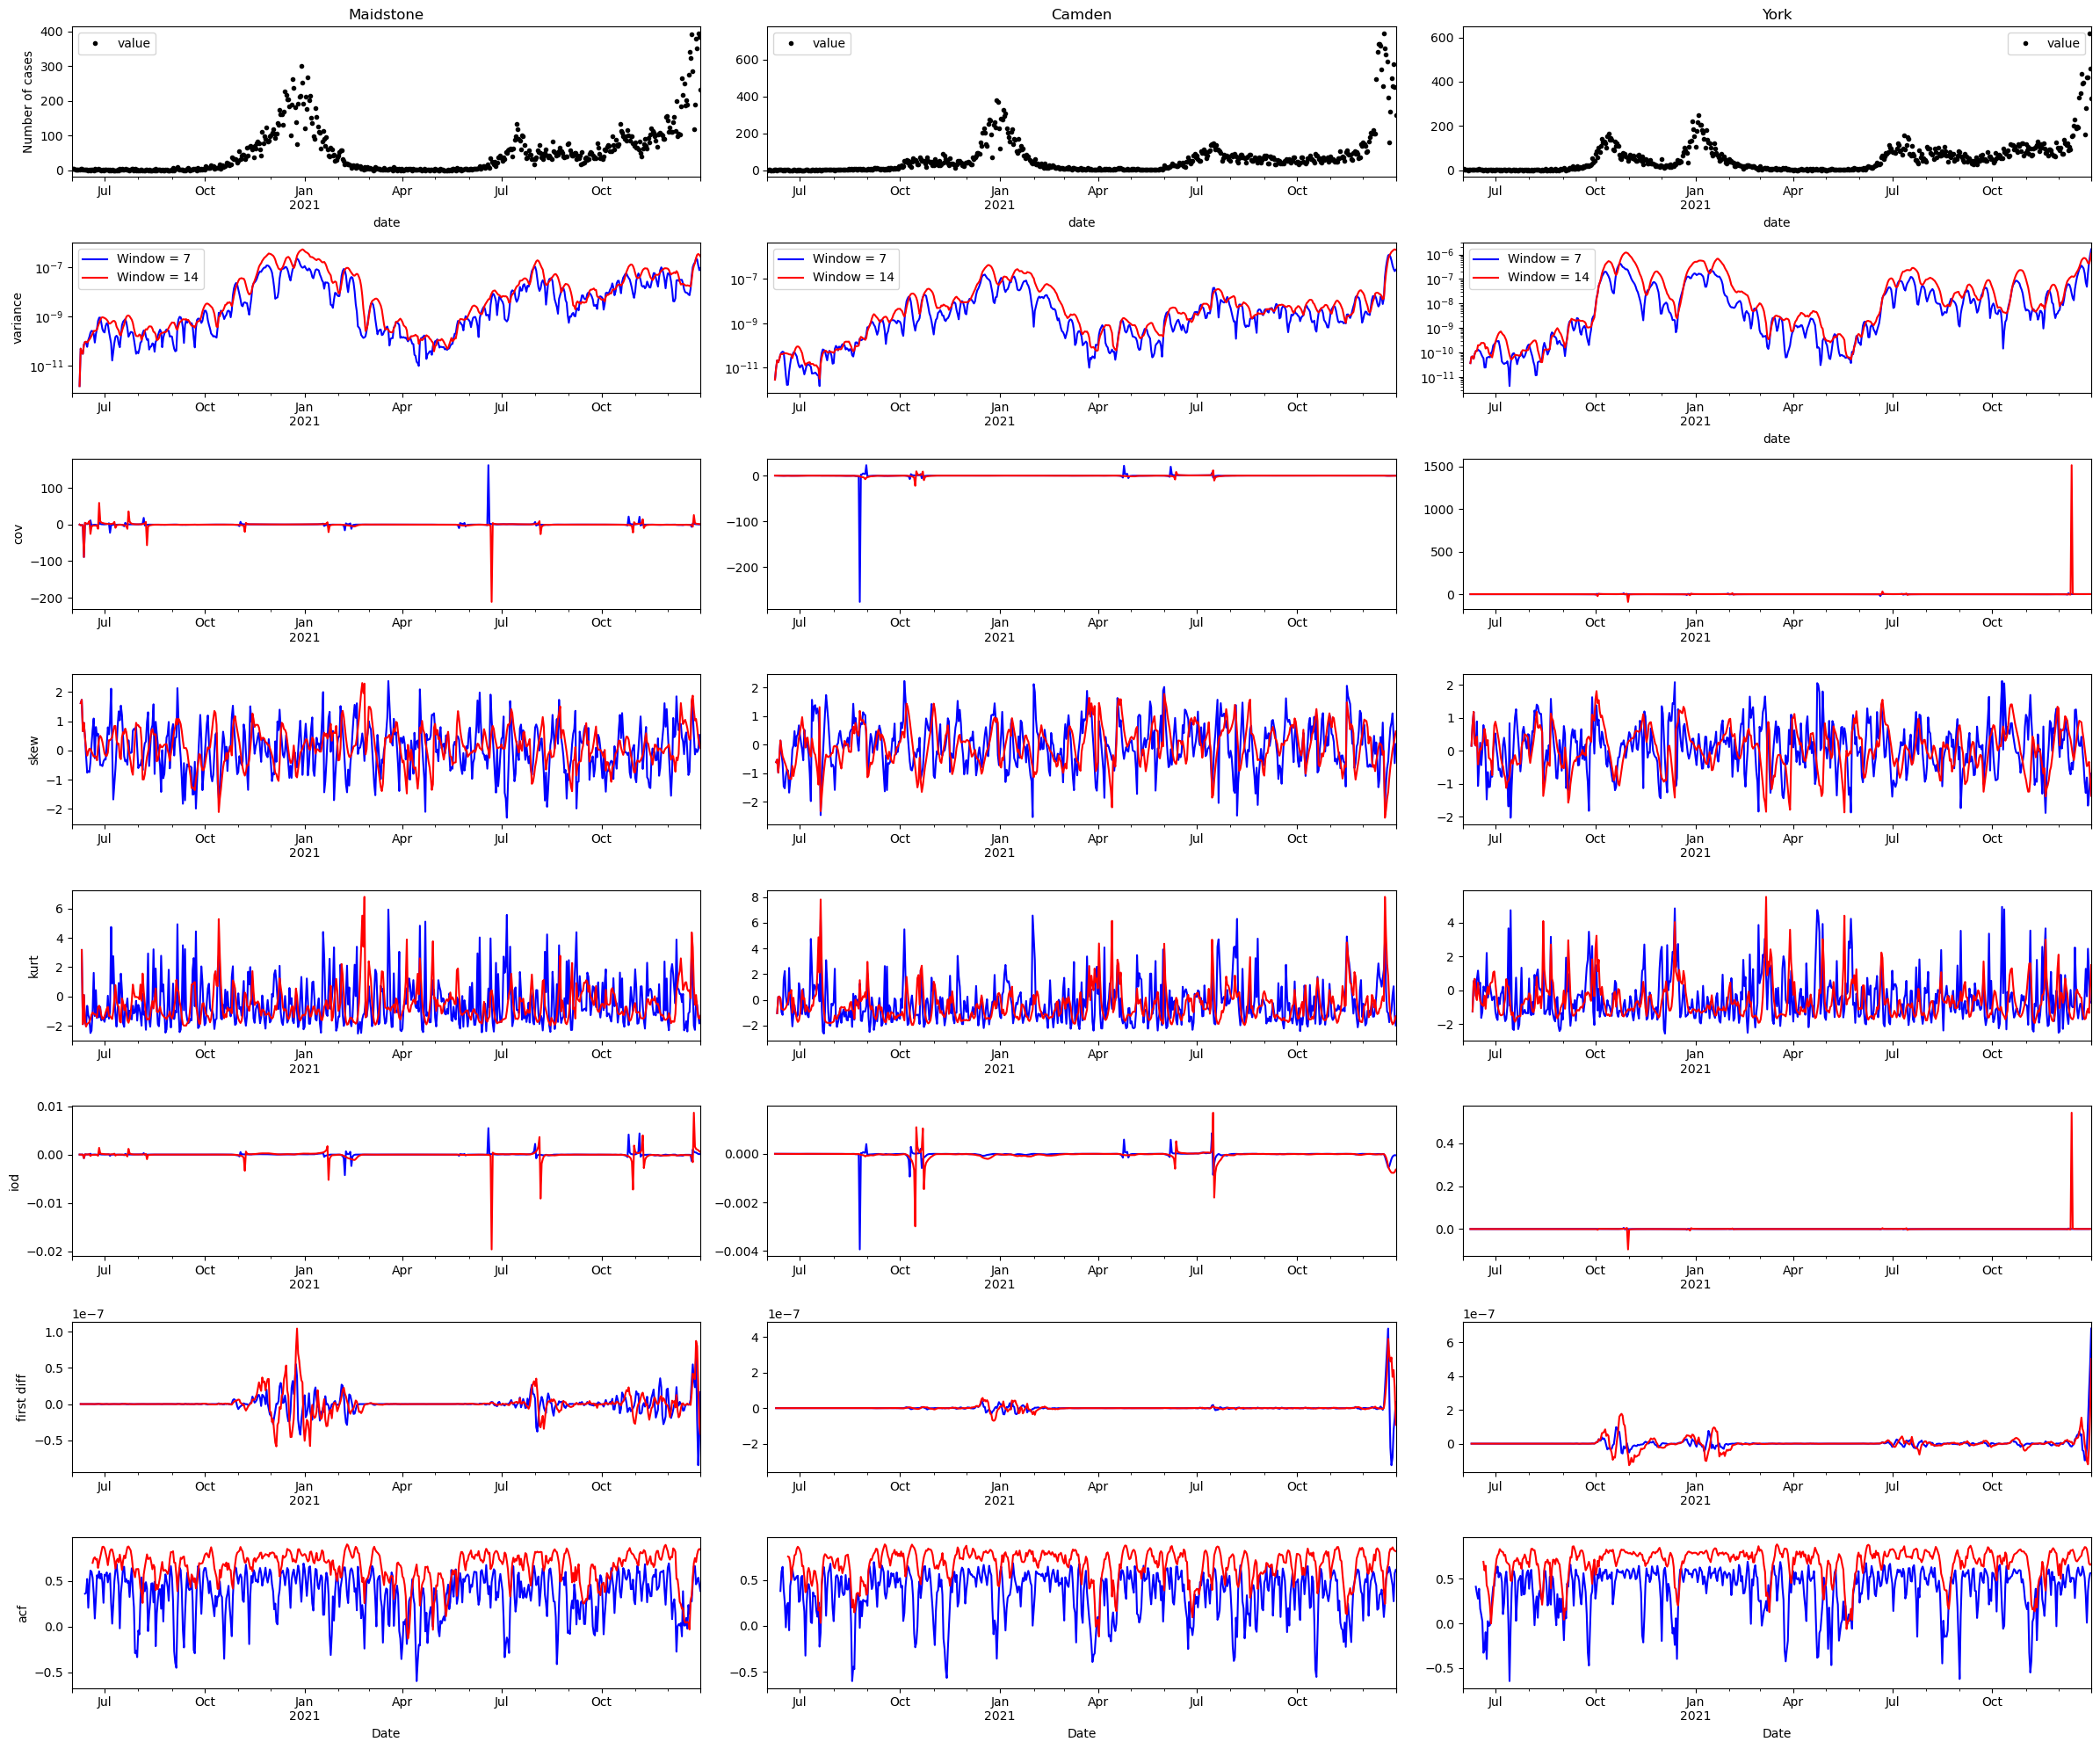

In [26]:
fig, axs = plt.subplots(nrows=len(ews_7total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')

for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_14total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,0],logy=True,color='red',label='Window = 14')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_14total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,1],logy=True,color='red',label='Window = 14')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['York']
    stat_data = ews_14total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,2],logy=True,color='red',label='Window = 14')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.tight_layout()
plt.savefig("Figures/spatialrolling714.pdf",dpi=2400,bbox_inches='tight')
plt.show()

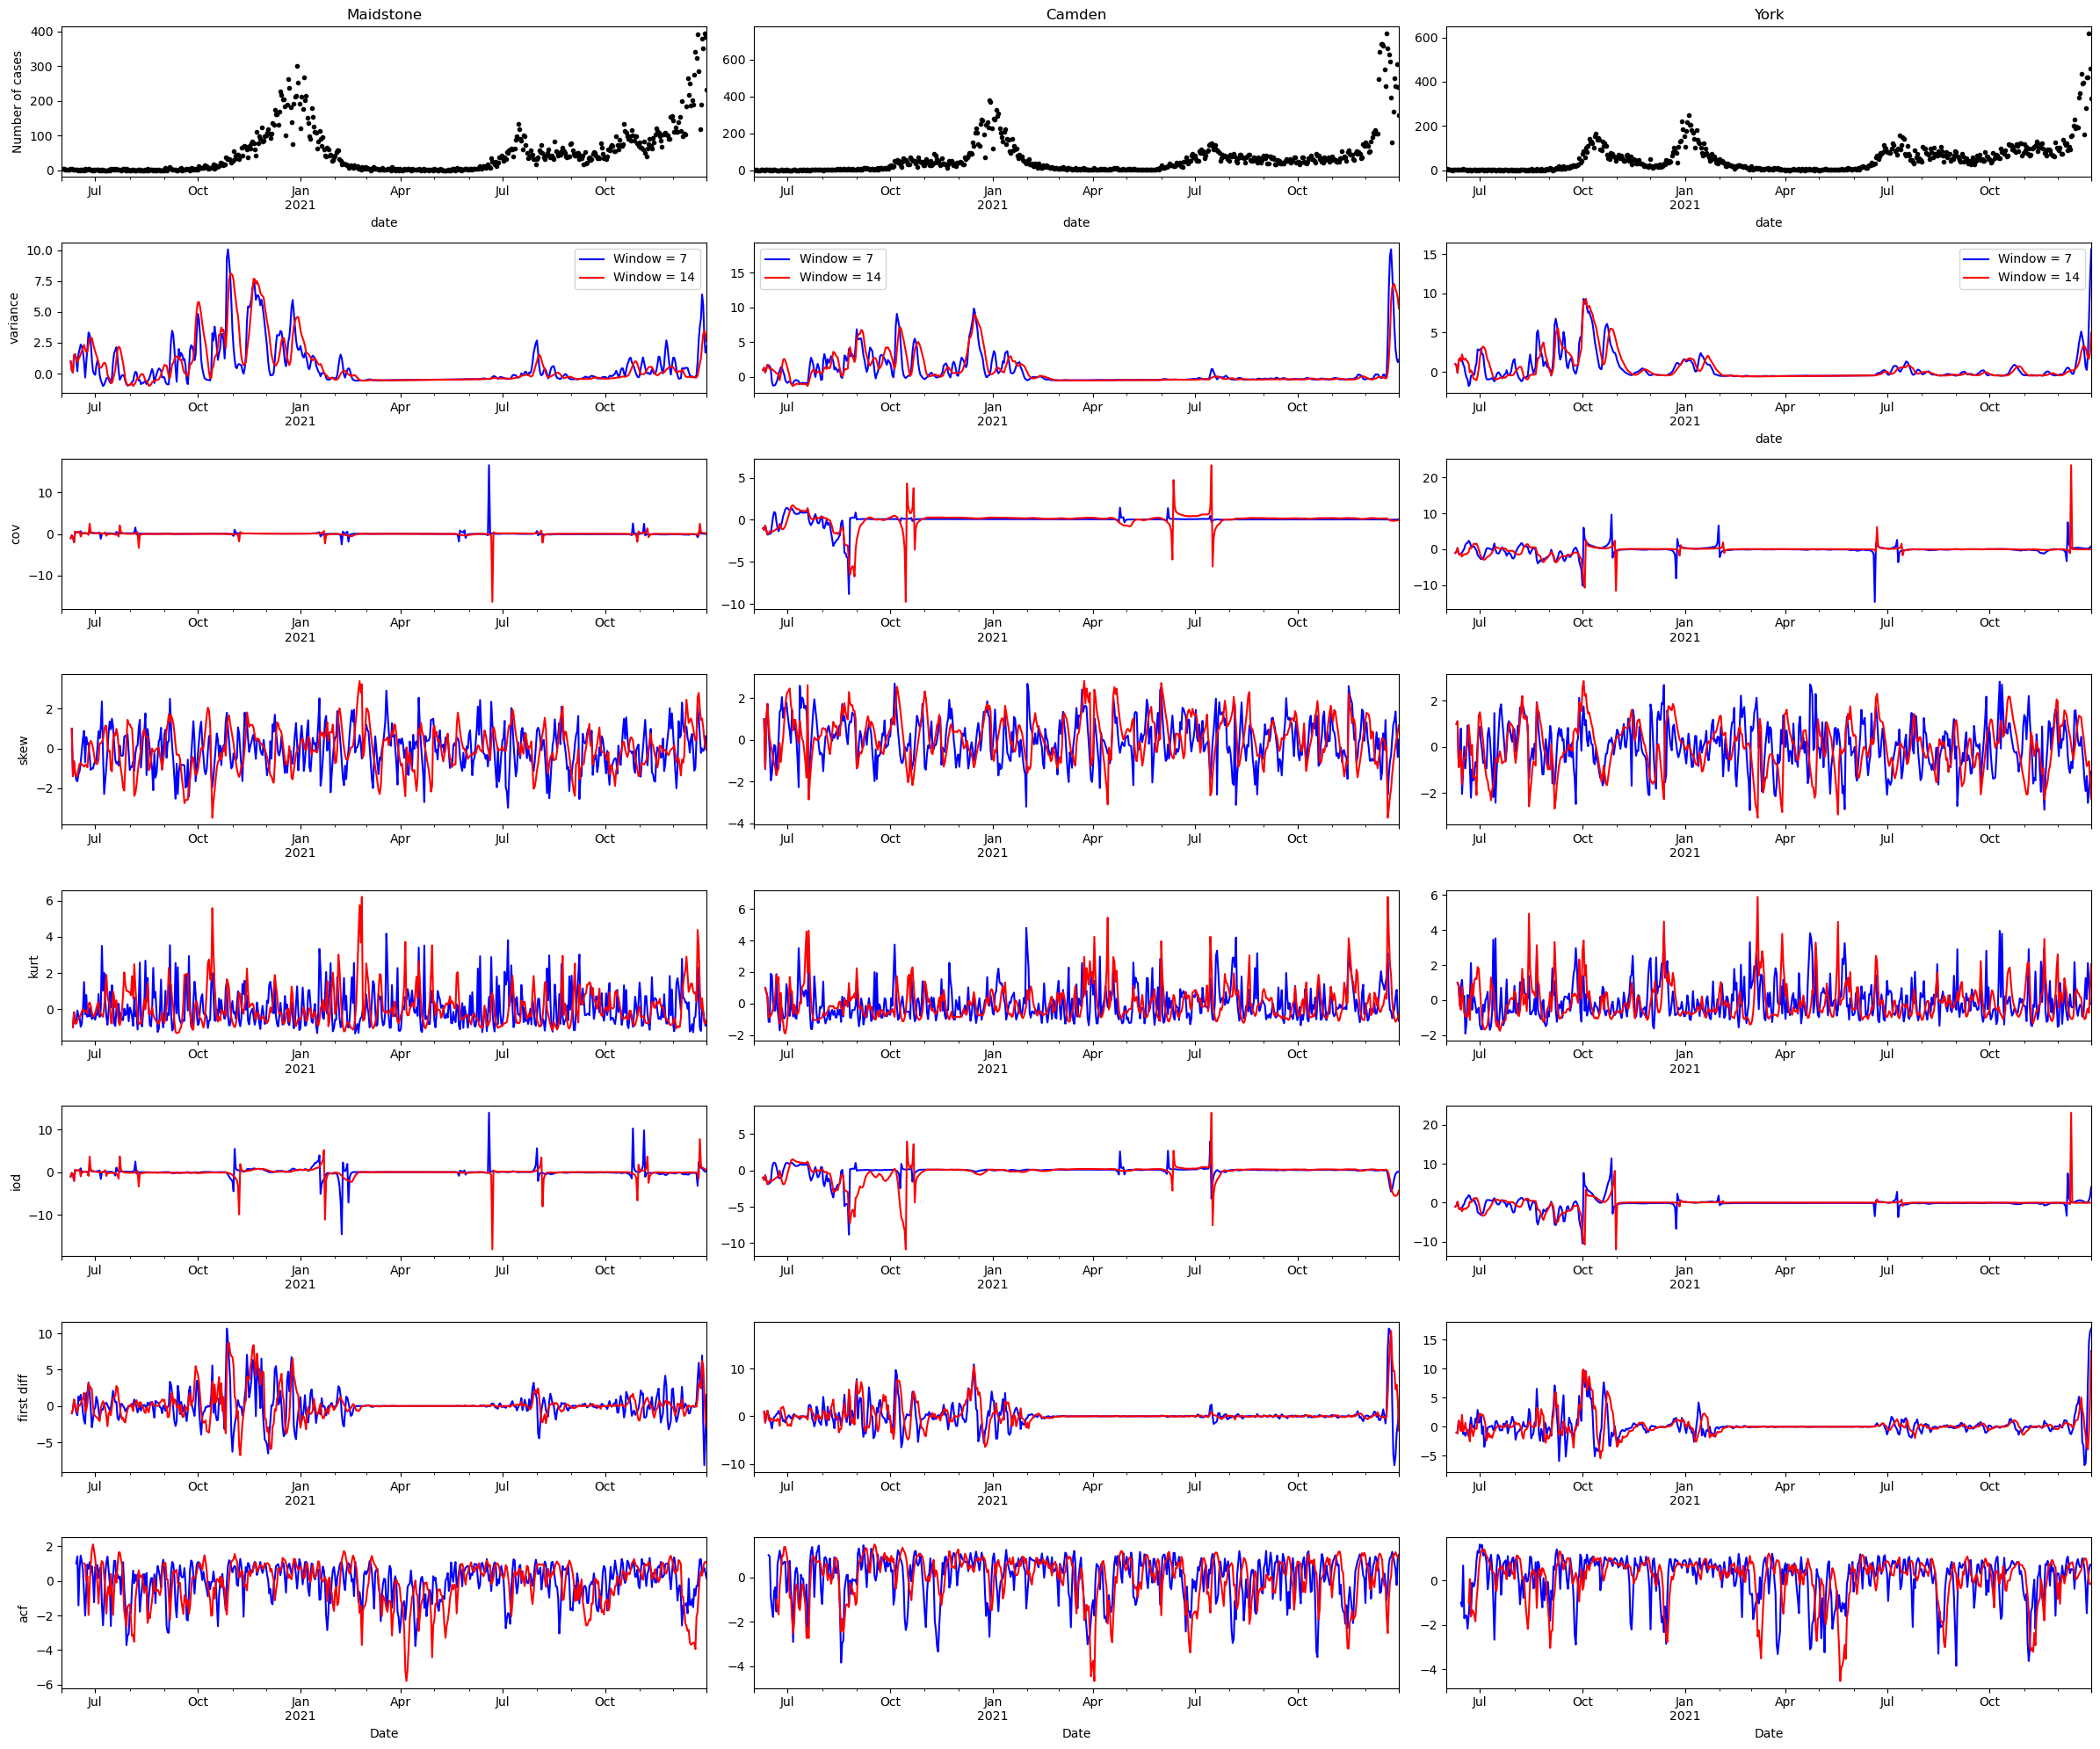

In [39]:
fig, axs = plt.subplots(nrows=len(norm_ews_7total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend=False)
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend=False)
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend=False)
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')

for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['Maidstone']
    stat_data = norm_ews_14total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,0],color='red',label='Window = 14')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['Camden']
    stat_data = norm_ews_14total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,1],color='red',label='Window = 14')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['York']
    stat_data = norm_ews_14total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,2],color='red',label='Window = 14')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.tight_layout()
plt.savefig("Figures/spatialrollingnormalised714.pdf",dpi=2400,bbox_inches='tight')
plt.show()

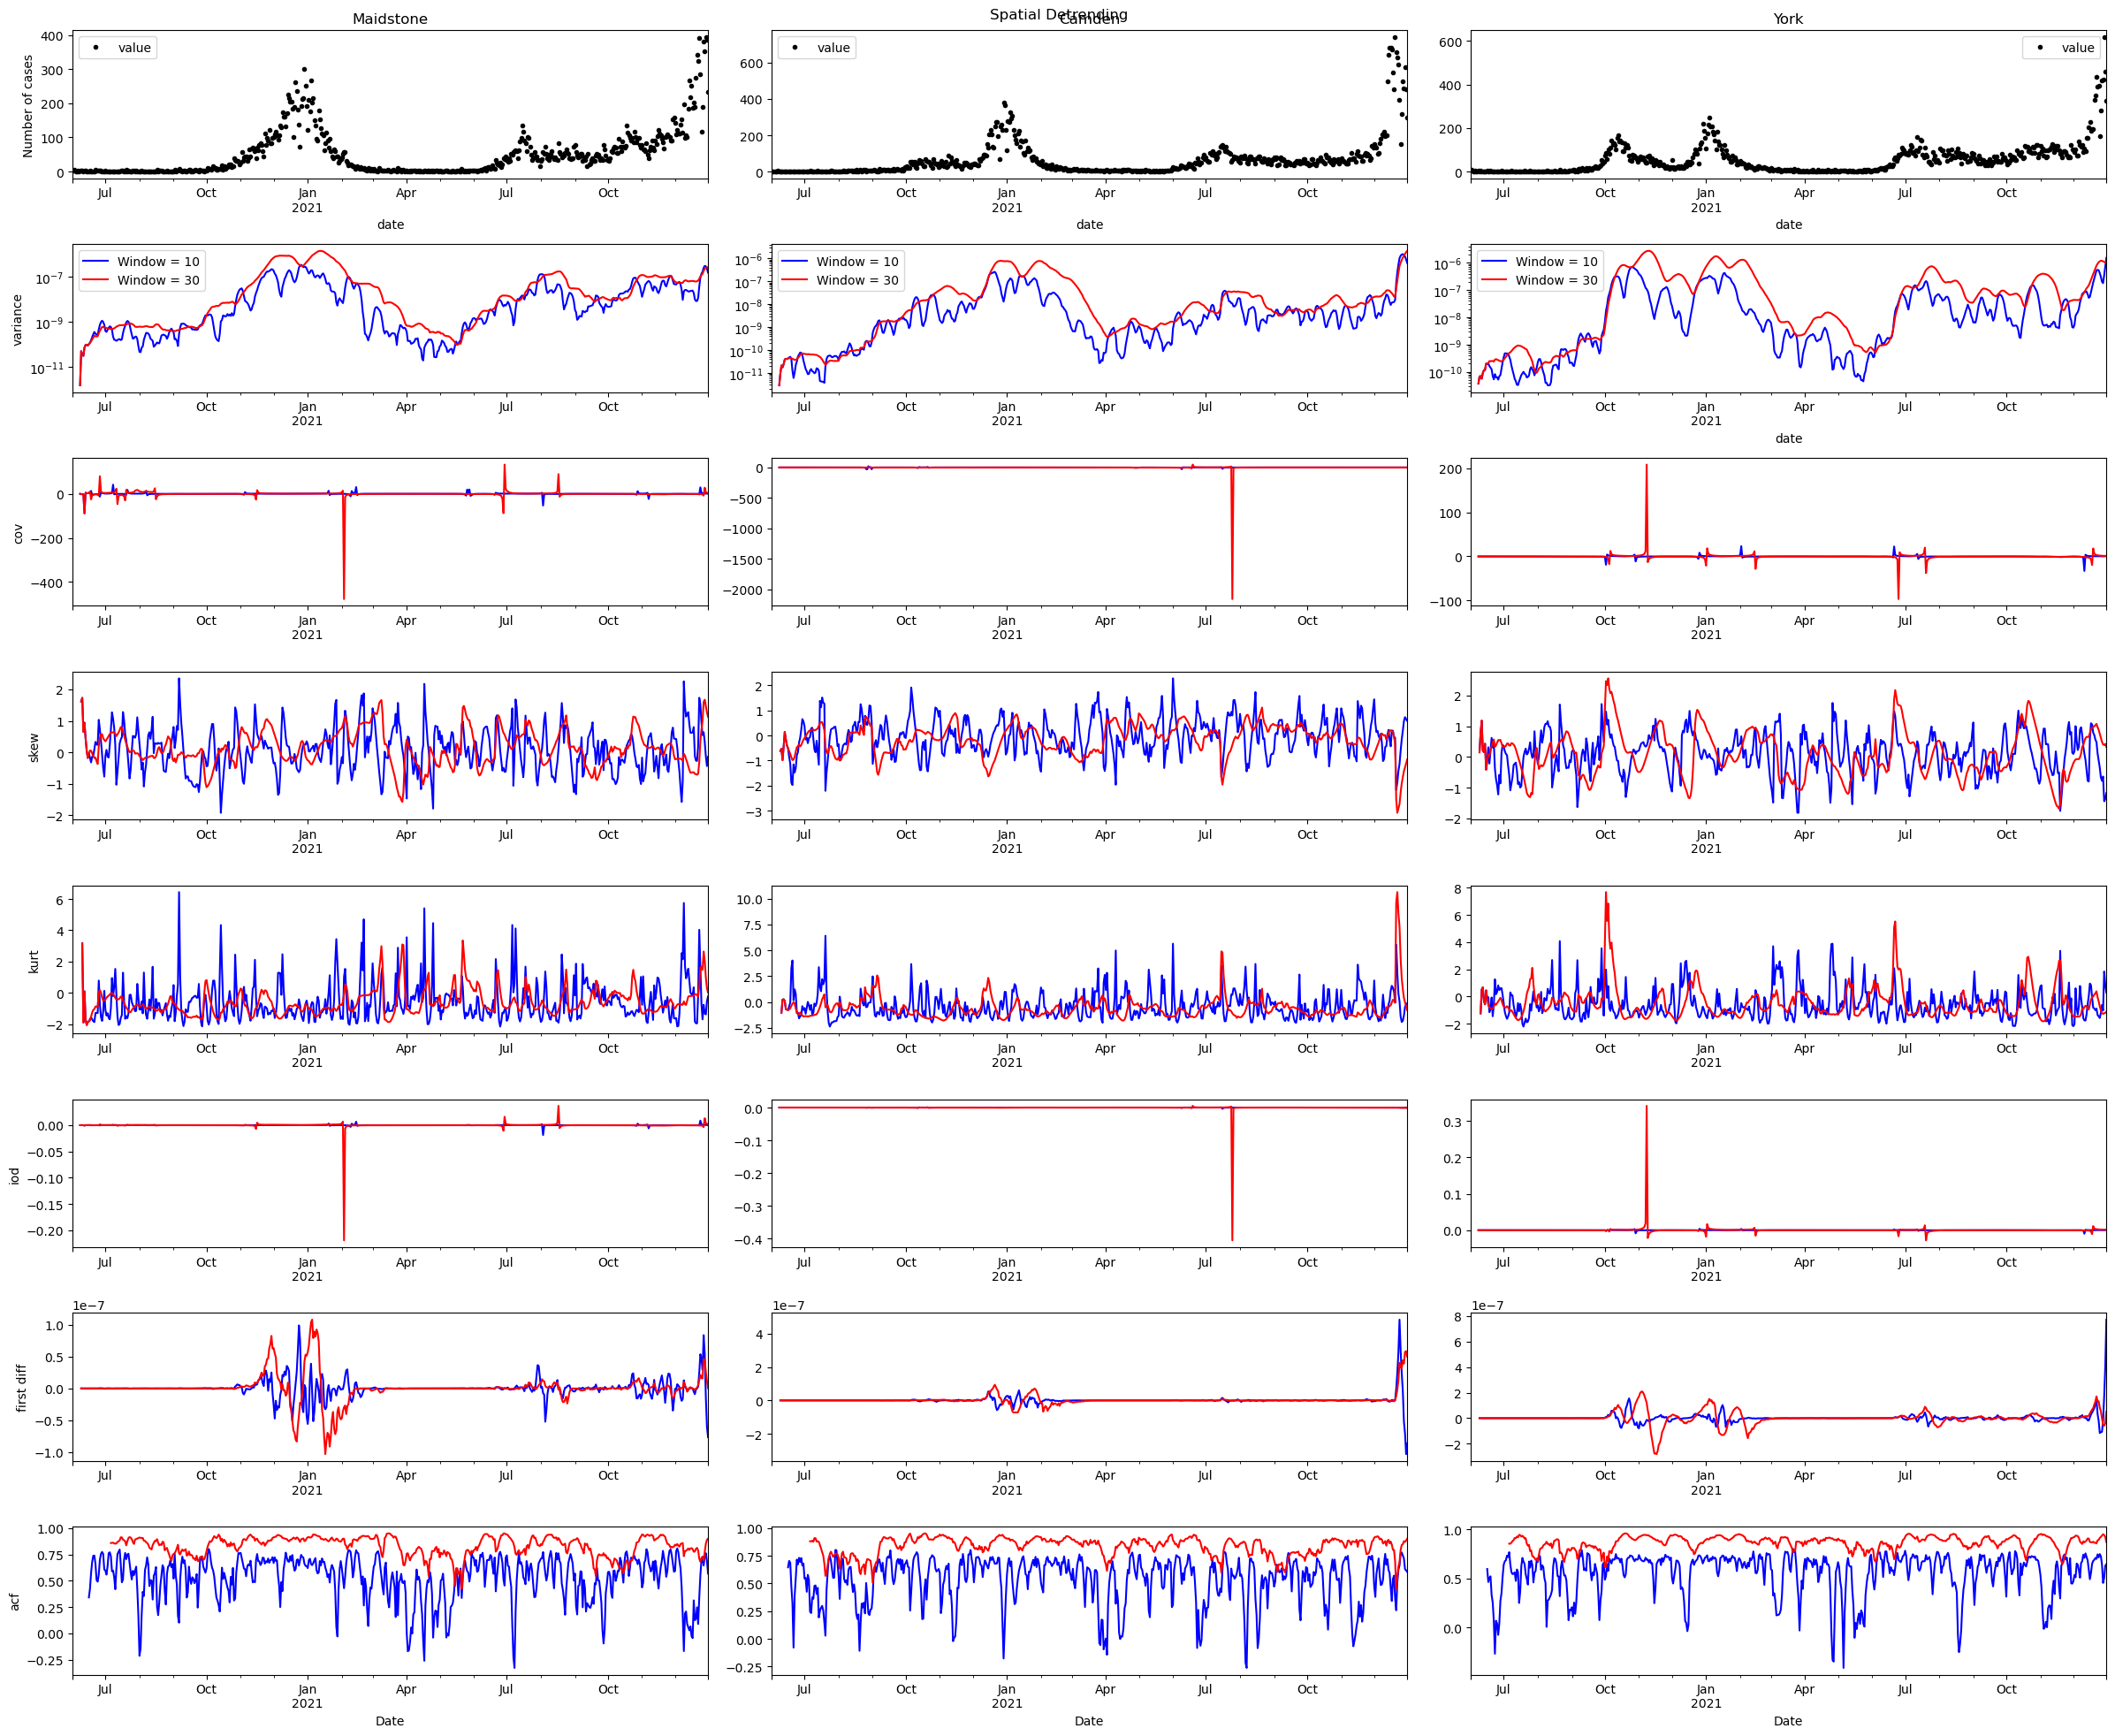

In [28]:
fig, axs = plt.subplots(nrows=len(ews_10total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')


for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_30total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,0],logy=True,color='red',label='Window = 30')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_30total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,1],logy=True,color='red',label='Window = 30')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_10total.keys()):
    stat_data = ews_10total[stat]
    y_data = stat_data['York']
    stat_data = ews_30total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i+1,2],logy=True,color='red',label='Window = 30')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/spatialrolling1030.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [29]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold(stat_timeseries):
    std_val, mean_val = long_run_averages(stat_timeseries)
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices
    
def loop_EWSs_store_results(ews_dict, ltlas):
    indices_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        for ltla in ltlas:
            stat_data = ews_dict[stat][ltla].values
            indices = exceed_threshold(stat_data)
            indices_dict[stat][ltla] = indices
    return indices_dict

In [30]:
two_sigma_test = loop_EWSs_store_results(norm_ews_7total,['Maidstone','Camden','York'])

/tmp/ipykernel_167988/3973742248.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [52]:
two_sigma_all = loop_EWSs_store_results(norm_ews_7total,norm_ews_7total['variance'].columns.values)
import pickle 
with open("Results/2sigma.pkl", "wb") as f:
    pickle.dump(two_sigma_all,f)

/tmp/ipykernel_167988/3973742248.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [87]:
import pickle
with open("Results/2sigma.pkl",'rb') as f:
    two_sigma_test = pickle.load(f)

/tmp/ipykernel_167988/3973742248.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_167988/3973742248.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_167988/3973742248.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=d

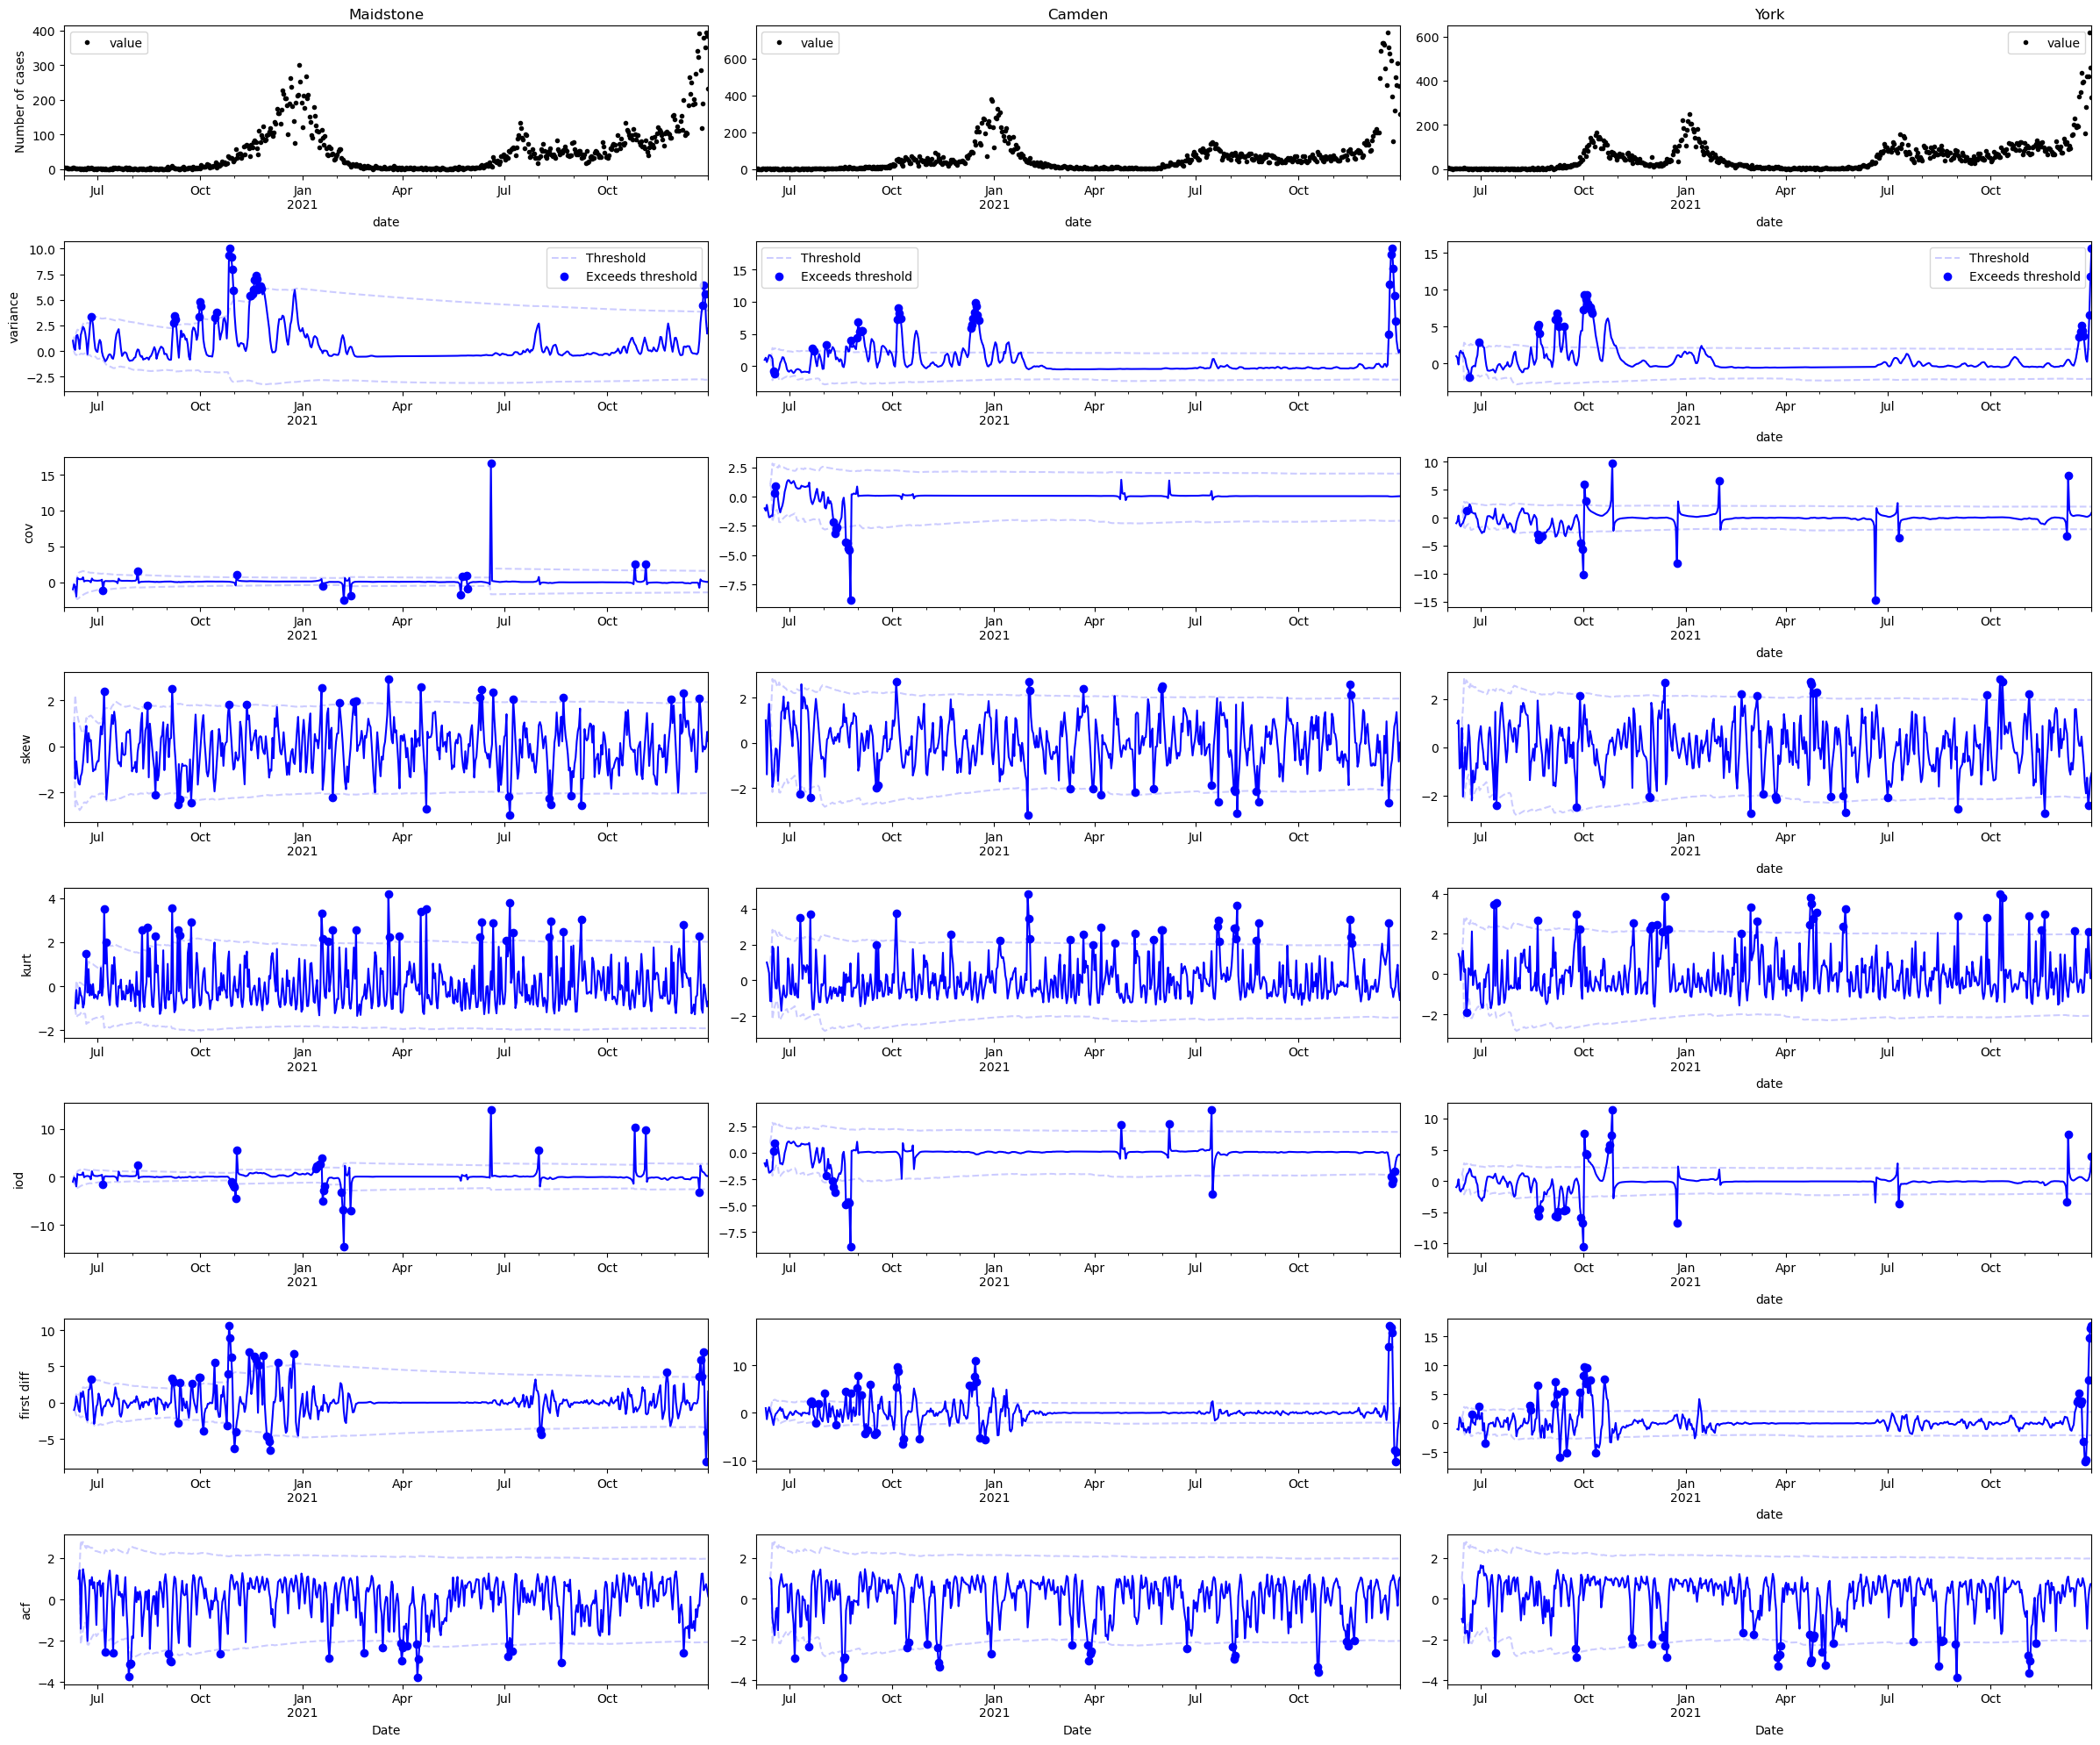

In [90]:
fig, axs = plt.subplots(nrows=len(norm_ews_7total.keys())+1,ncols=3,figsize=(24,20))
cases[cases['area_name']=='Maidstone'].plot(y='value',style='.',ax=axs[0,0],color='black',legend='False')
axs[0,0].set_title('Maidstone')
cases[cases['area_name']=='Camden'].plot(y='value',style='.',ax=axs[0,1],color='black',legend='False')
axs[0,1].set_title('Camden')
cases[cases['area_name']=='York'].plot(y='value',style='.',ax=axs[0,2],color='black',legend='False')
axs[0,2].set_title('York')
axs[0,0].set_ylabel('Number of cases')

for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['Maidstone'].copy(deep=True)
    std_val, mean_val = long_run_averages(y_data.values)
    y_data.plot(ax=axs[i+1,0],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,0],x='date',y='Top',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data.plot(ax=axs[i+1,0],x='date',y='Bottom',color='blue',alpha=0.2,style='--',label='')
    y_data = y_data.iloc[two_sigma_test[stat]['Maidstone']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,0],y='Maidstone',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,0].legend()
    else:
        axs[i+1,0].get_legend().set_visible(False)
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_14total[stat]
    y_data.plot(ax=axs[i+1,1],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,1],x='date',y='Top',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data.plot(ax=axs[i+1,1],x='date',y='Bottom',color='blue',alpha=0.2,style='--',legend=False)
    y_data = y_data.iloc[two_sigma_test[stat]['Camden']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,1],y='Camden',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,0].legend()
    else:
        axs[i+1,1].get_legend().set_visible(False)
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(norm_ews_7total.keys()):
    stat_data = norm_ews_7total[stat]
    y_data = stat_data['York']
    y_data.plot(ax=axs[i+1,2],color='blue',label='')
    y_data = y_data.reset_index()
    y_data['Top'] = mean_val + 2*std_val
    y_data['Bottom'] = mean_val - 2*std_val
    y_data.set_index('date')
    y_data.plot(ax=axs[i+1,2],x='date',y='Top',color='blue',alpha=0.2,style='--',legend=False)
    y_data.plot(ax=axs[i+1,2],x='date',y='Bottom',color='blue',alpha=0.2,style='--',label='Threshold')
    y_data = y_data.iloc[two_sigma_test[stat]['York']].drop(columns=['Top','Bottom']).set_index('date')
    y_data.plot(ax=axs[i+1,2],y='York',color='blue',style='o',label='Exceeds threshold')
    if (stat == "variance"):
        axs[i+1,0].legend()
    else:
        axs[i+1,2].get_legend().set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.tight_layout()
plt.savefig("Figures/spatialrolling2sigma.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [36]:
# Function to calculate spatial EWS
def calculate_spatial_ews(long_data):
    # rolling = long_data.groupby(['region','date']).rolling(window=window_size,center=False, min_periods=1)
    # variance = rolling.var(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    # skew = rolling.skew(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    grouped = long_data.groupby(['region','date'])
    variance = grouped.var(1,numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'variance'}).set_index('date')
    skew = grouped.skew(numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'skew'}).set_index('date')
    skew.insert(2,'variance',variance['variance'].values)
    ews_data = skew.copy(deep=True)
    return ews_data
    # normalised_ews_data = ews_data.copy(deep=True)
    # for ews in ['skew','variance']:
    #     normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    # return ews_data, normalised_ews_data

In [37]:
# Consider spatial EWS across regions
# Group by region and consider spatial skew and variance
spatial_ews = calculate_spatial_ews(weekly_counts_total)

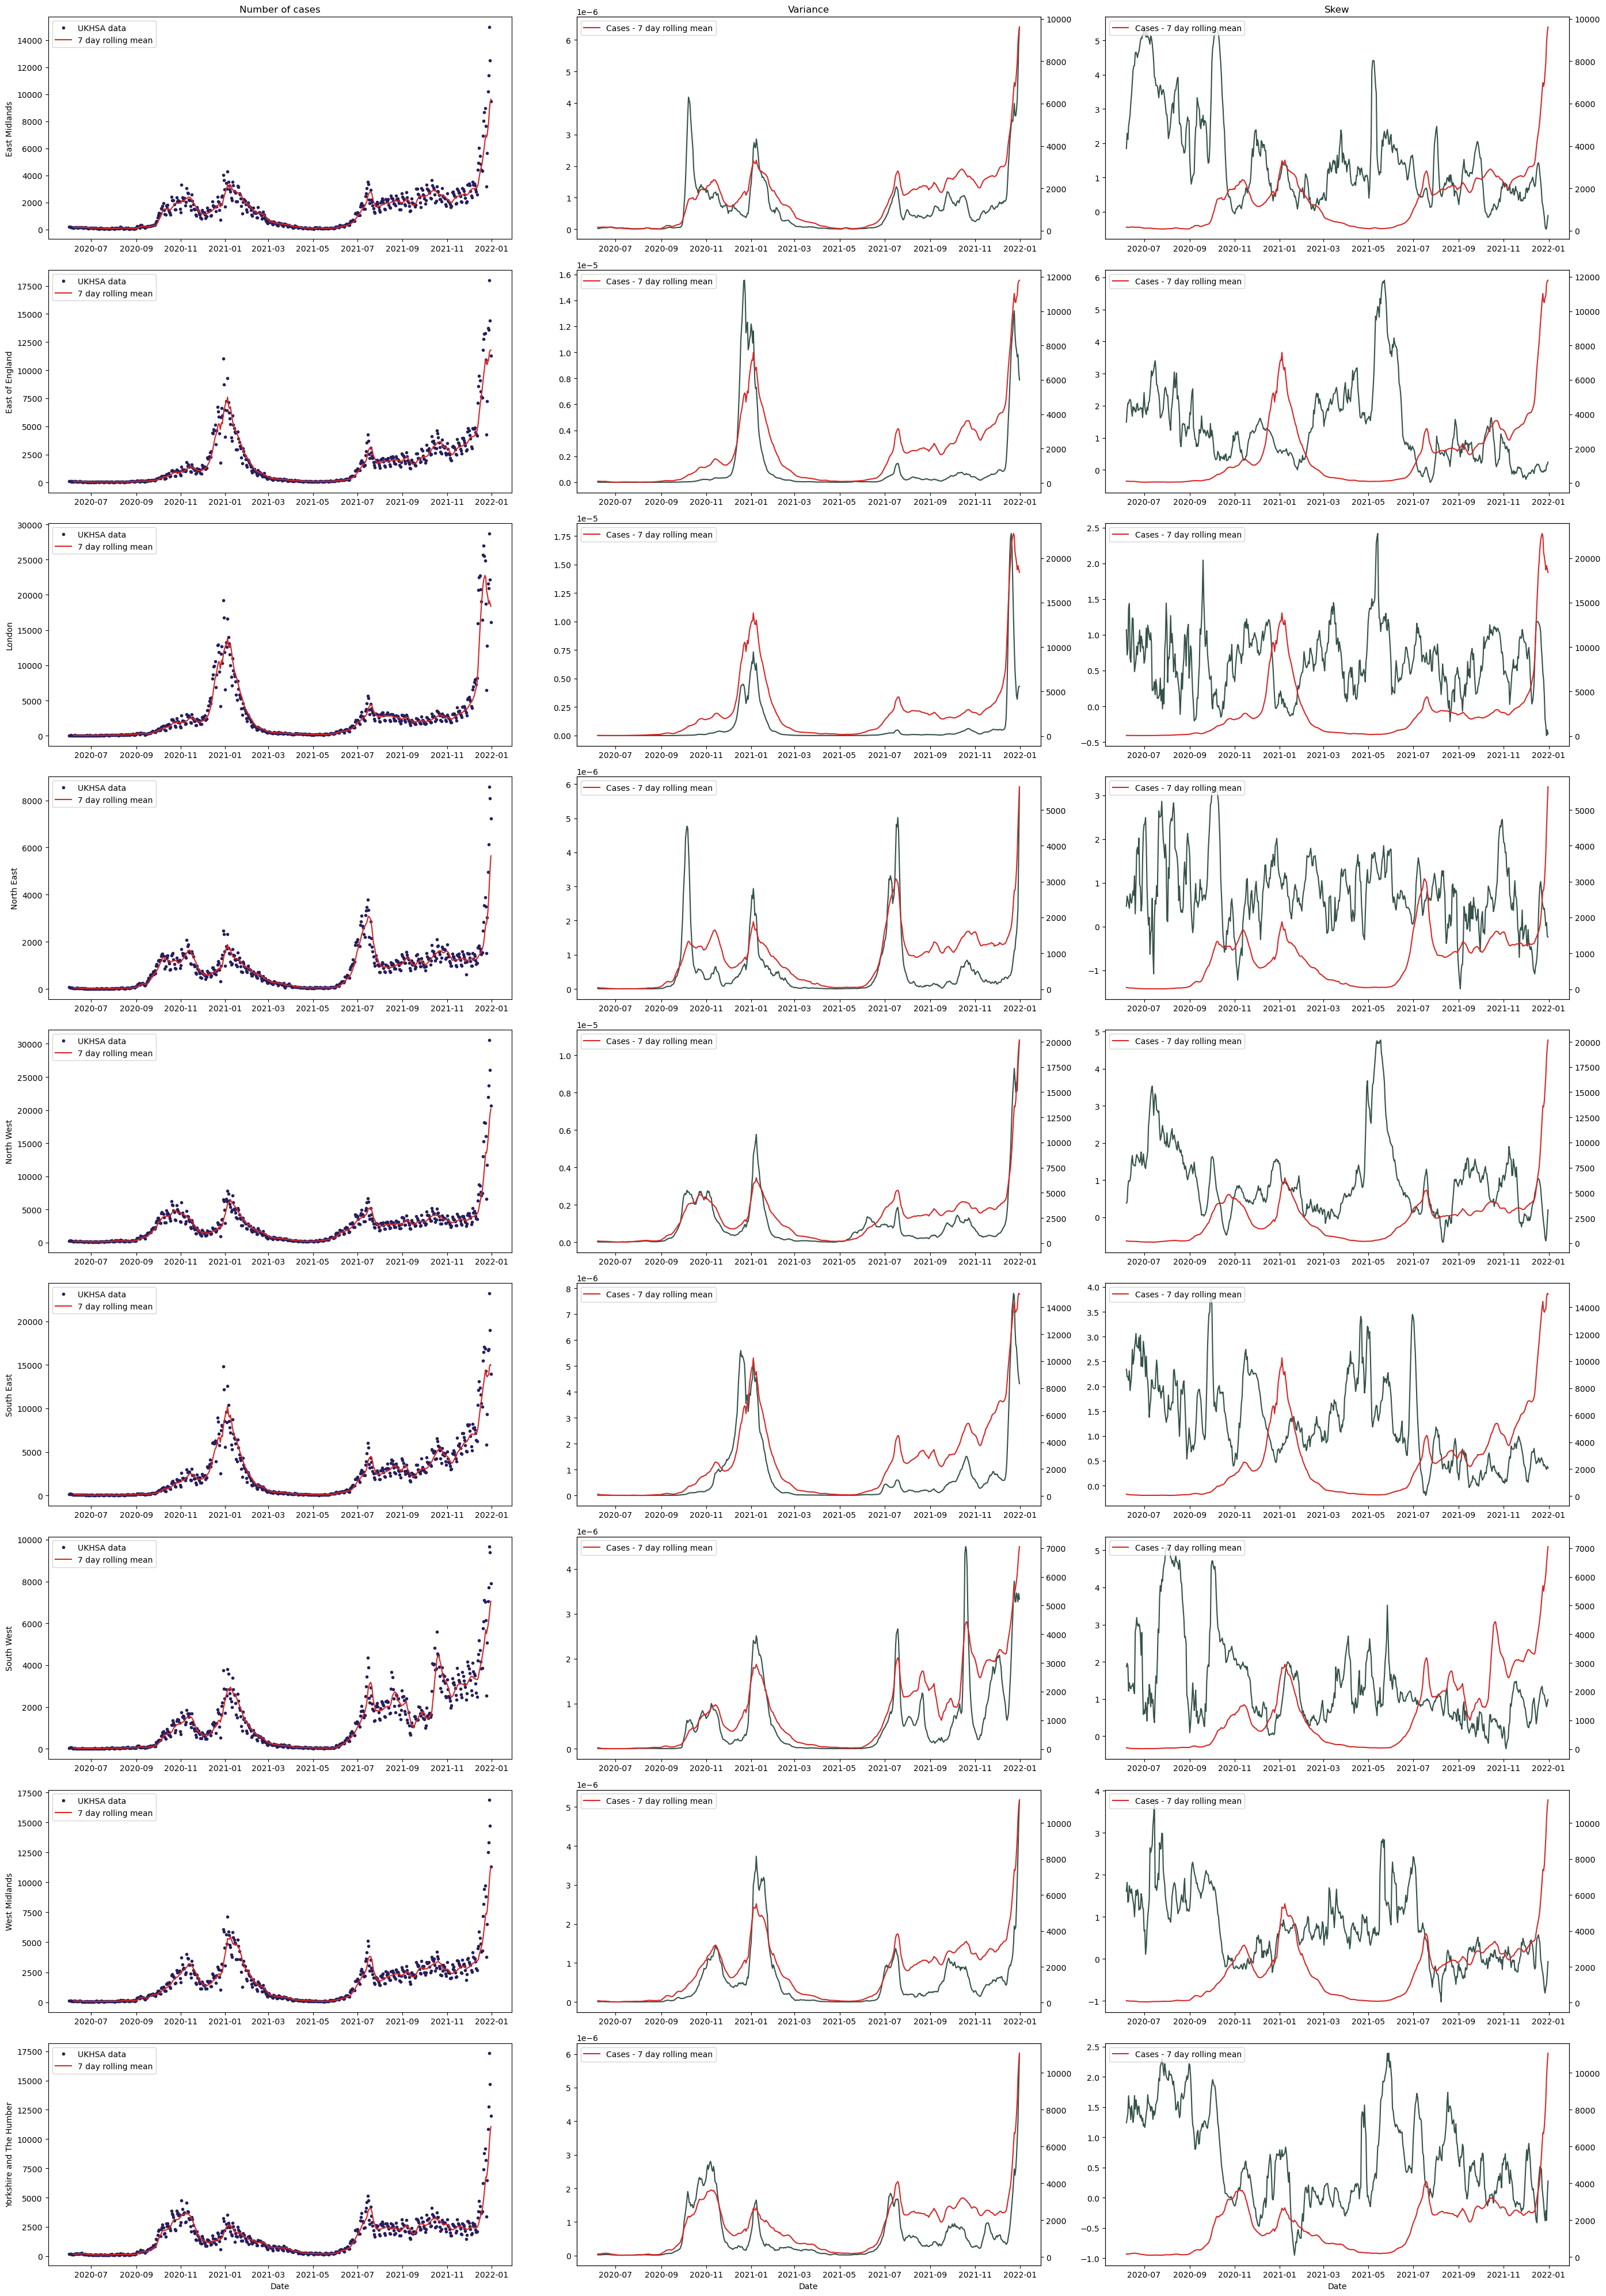

In [44]:
# Plot spatial EWS for each group
num_regions = len(np.unique(spatial_ews['region'].values))
regions = np.unique(spatial_ews['region'].values)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(28,40))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','skew']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            
            ax.legend()
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            ax2 = ax.twinx()
            ax2.plot(counts['date'],counts['rolling'],color='#D62828',label='Cases - 7 day rolling mean')
            ax2.legend()
            signal_data = spatial_ews[spatial_ews['region'] == region][['region',signal]].reset_index()
            ax.plot(signal_data['date'],signal_data[signal],color='#35524A')
            ax.xaxis.label.set_visible(False)
        
        if col == 0:
            axs[row,col].set_ylabel(region)

titles = ['Number of cases','Variance','Skew']
for i in range(3):
    axs[0,i].set_title(titles[i])
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/spatialsignalsregional.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [45]:
# Consider spatial EWS across country
# Consider spatial skew and variance
# Function to calculate spatial EWS
def calculate_spatial_ews_country(long_data):
    # rolling = long_data.groupby(['region','date']).rolling(window=window_size,center=False, min_periods=1)
    # variance = rolling.var(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    # skew = rolling.skew(1,numeric_only=True)['detrended'].reset_index().drop(columns='level_2').rename(columns={'detrended':'variance'})
    grouped = long_data.groupby('date')
    variance = grouped.var(1,numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'variance'}).set_index('date')
    skew = grouped.skew(numeric_only=True)['detrended'].reset_index().rename(columns={'detrended':'skew'}).set_index('date')
    skew.insert(1,'variance',variance['variance'].values)
    ews_data = skew.copy(deep=True)
    return ews_data
    # normalised_ews_data = ews_data.copy(deep=True)
    # for ews in ['skew','variance']:
    #     normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    # return ews_data, normalised_ews_data

In [46]:
# Get EWS across country
ews_data_country = calculate_spatial_ews_country(weekly_counts_total)

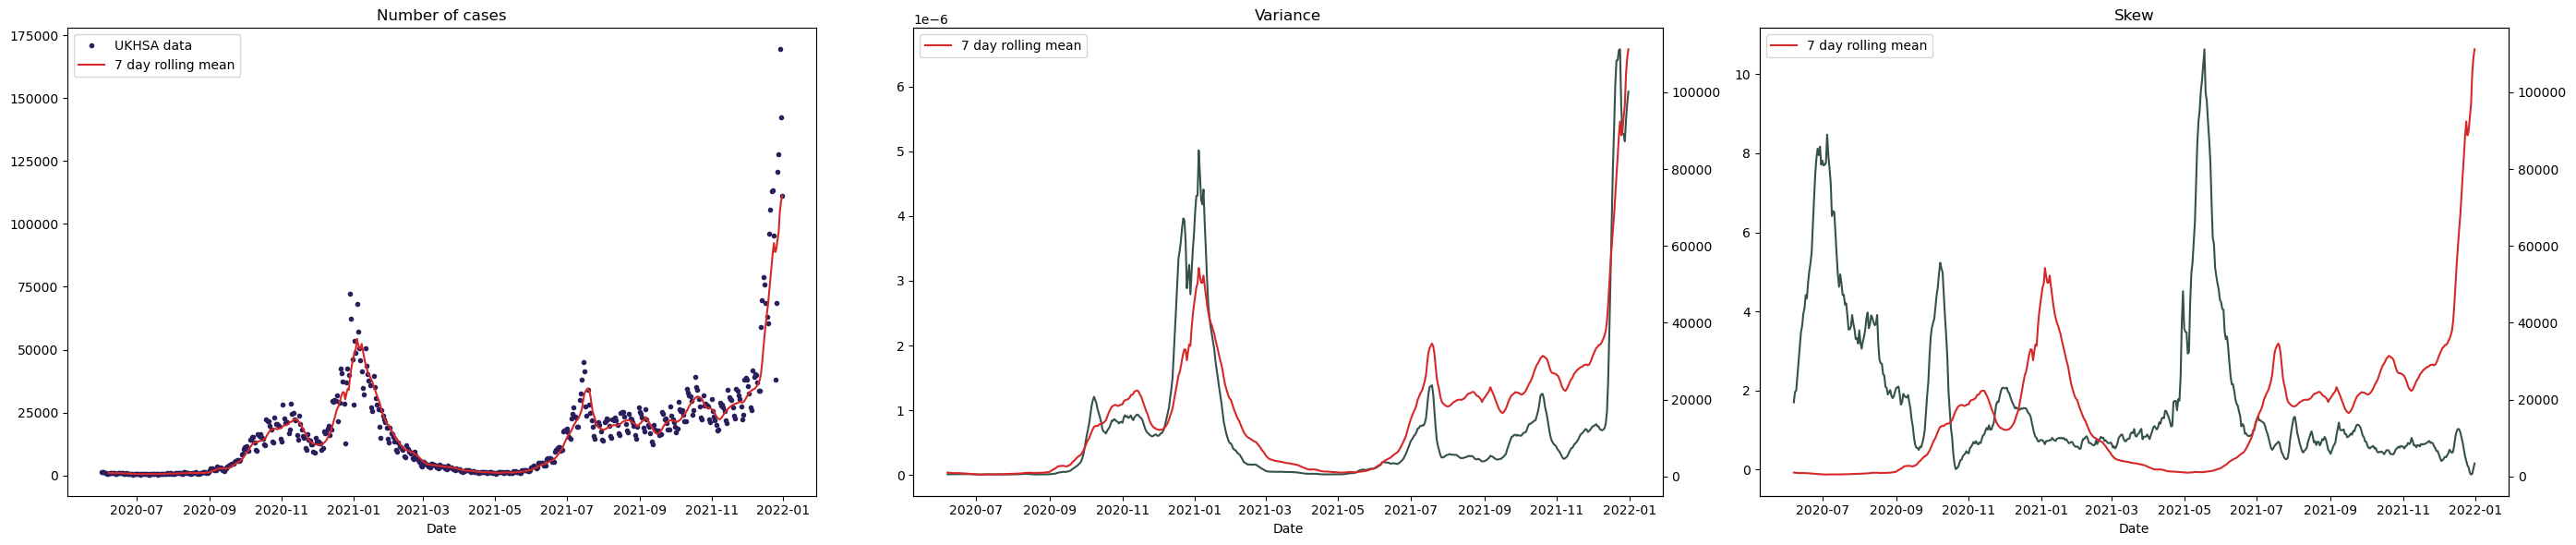

In [48]:
# Plot spatial EWS across country
num_regions = len(np.unique(spatial_ews['region'].values))
regions = np.unique(spatial_ews['region'].values)
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(28,6))
titles = ['Number of cases','Variance','Skew']
signals = ['variance','skew']
for col in range(3):
    ax = axs[col]
    counts = cases.groupby('date').sum(numeric_only=True)['value'].reset_index()
    counts['rolling'] = counts['value'].rolling(7).mean()
    if col == 0:
        ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
        ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
        ax.legend()
    else:
        signal = signals[col-1]
        signal_data = ews_data_country[signal].reset_index()
        ax.plot(signal_data['date'],signal_data[signal],color='#35524A')
        ax2 = ax.twinx()
        ax2.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
        ax2.legend()
    ax.set_title(titles[col])
    ax.set_xlabel('Date')


plt.tight_layout()
plt.savefig("Figures/spatialsignalscountry.pdf",dpi=2400,bbox_inches='tight')
plt.show()
    